In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

fatal: destination path 'adahessian' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")

In [4]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# classic dataset 
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [7]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [8]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets 
print(labels)

[0 1 2 3 4 5 6 7 8 9]


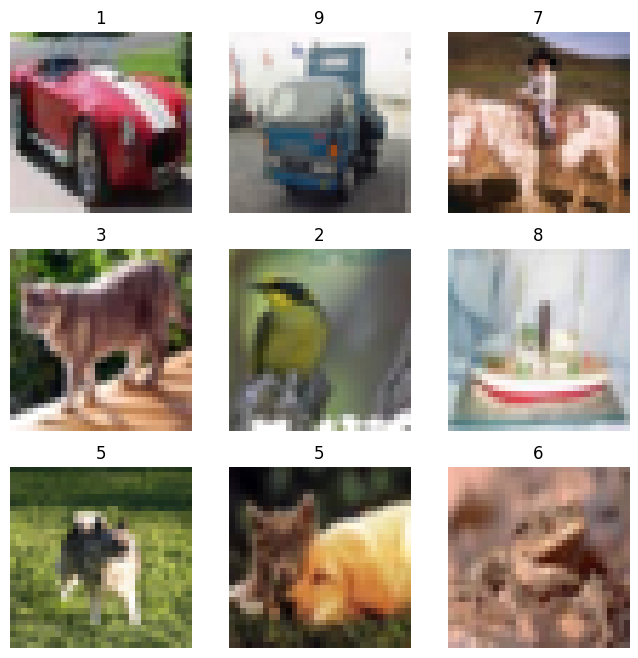

In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [10]:
batch_size = 16
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [12]:
def set_parameter_requires_grad(model, req_grad):
    if not req_grad:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
req_grad = True

def initialize_model(input_channel=3, output_size=10, req_grad=True, use_pretrained=True):

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, req_grad)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, output_size)
    input_size = 32
    #conv1_out_channel = model_ft.conv1.out_channels
    #model_ft.conv1 = nn.Conv2d(input_channel, conv1_out_channel, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return model_ft, input_size

# Initialize the model for this run
model, input_size = initialize_model()

# Print the model we just instantiated
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Send the model to GPU
model = model.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [15]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epoch = 20
lowest_loss = 100000
model_weights = None

In [16]:
def train(model, dataloader, criterion, optimizer, epoch):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(dataloader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      inputs = inputs.float()

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      # print statistics
      running_loss += loss.item() * inputs.size(0)
  epoch_loss = running_loss / len(dataloader.dataset)
  print('Train Loss: {:.4f}'.format(epoch_loss))

In [17]:
def test(model, dataloader, criterion, optimizer, epoch, best_loss, best_model_wts):
  model.eval()
  running_loss = 0.0
  for i, data in enumerate(dataloader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      inputs = inputs.float()

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
  epoch_loss = running_loss / len(dataloader.dataset)
  print('Test Loss: {:.4f}'.format(epoch_loss))
  if(epoch_loss < best_loss and epoch > num_epoch/2):
    best_loss = epoch_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(best_model_wts, './drive/MyDrive/Opti-ML/model_weights/model_1.pt')
  return best_loss, best_model_wts

In [18]:
for epoch in range(num_epoch):
  if(epoch%1==0):
    print('Epoch {}/{}'.format(epoch, num_epoch-1))
    print('-' * 10)
  train(model, trainloader, criterion, optimizer, epoch)
  lowest_loss, model_weights = test(model, testloader, criterion, optimizer, epoch, lowest_loss, model_weights)

Epoch 0/19
----------
Train Loss: 1.1279
Test Loss: 0.7866
Epoch 1/19
----------
Train Loss: 0.7626
Test Loss: 0.6703
Epoch 2/19
----------
Train Loss: 0.6208
Test Loss: 0.5883
Epoch 3/19
----------
Train Loss: 0.5243
Test Loss: 0.5700
Epoch 4/19
----------
Train Loss: 0.4478
Test Loss: 0.5790
Epoch 5/19
----------
Train Loss: 0.3850
Test Loss: 0.6099
Epoch 6/19
----------
Train Loss: 0.3286
Test Loss: 0.5550
Epoch 7/19
----------
Train Loss: 0.2911
Test Loss: 0.5760
Epoch 8/19
----------
Train Loss: 0.2483
Test Loss: 0.6040
Epoch 9/19
----------
Train Loss: 0.2183
Test Loss: 0.6038
Epoch 10/19
----------
Train Loss: 0.1917
Test Loss: 0.6357
Epoch 11/19
----------
Train Loss: 0.1710
Test Loss: 0.6233
Epoch 12/19
----------
Train Loss: 0.1480
Test Loss: 0.6592
Epoch 13/19
----------
Train Loss: 0.1284
Test Loss: 0.6544
Epoch 14/19
----------
Train Loss: 0.1171
Test Loss: 0.6710
Epoch 15/19
----------
Train Loss: 0.1040
Test Loss: 0.7066
Epoch 16/19
----------
Train Loss: 0.0930
Test Los

In [19]:
model.load_state_dict(torch.load('./drive/MyDrive/Opti-ML/model_weights/model_1.pt', map_location=torch.device('cpu')))
model.eval()
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
num_cor = 0
for i, data in enumerate(testloader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      inputs = inputs.float()

      prediction = model(inputs)
      prediction = torch.argmax(prediction)
      #print("gt:", labels, "pred:", prediction)
      if(labels == prediction):
        num_cor += 1
acc = num_cor / len(testloader.dataset)
print(acc)

0.8239
